In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [3]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


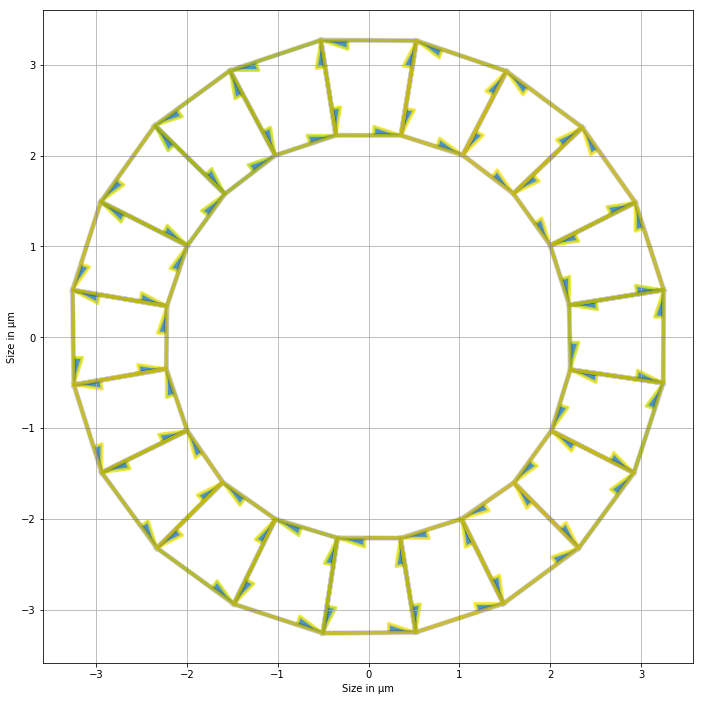

In [6]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.051, 0.052, 0.051, 0.050,
    0.049, 0.050, 0.051, 0.050, 0.051,
    0.050, 0.049, 0.048, 0.049, 0.050,
    0.051, 0.052, 0.051, 0.050, 0.049
])

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = np.roll(3*np.array([
    0.050, 0.051, 0.052, 0.051, 0.050,
    0.049, 0.050, 0.051, 0.050, 0.051,
    0.050, 0.049, 0.048, 0.049, 0.050,
    0.051, 0.052, 0.051, 0.050, 0.049
]), 1)

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.051, 0.052, 0.051, 0.050,
    0.049, 0.050, 0.051, 0.050, 0.051,
    0.050, 0.049, 0.048, 0.049, 0.050,
    0.051, 0.052, 0.051, 0.050, 0.049,
    0.051, 0.052, 0.051, 0.050,
    0.049, 0.050, 0.051, 0.050, 0.051,
    0.050, 0.049, 0.048, 0.049, 0.050,
    0.051, 0.052, 0.051, 0.050, 0.049, 0.050
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [7]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo3.Nf),[1000]*(3*organo3.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_eq_cst_per_cell.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

In [8]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.150
1     0.153
2     0.156
3     0.153
4     0.150
5     0.147
6     0.150
7     0.153
8     0.150
9     0.153
10    0.150
11    0.147
12    0.144
13    0.147
14    0.150
15    0.153
16    0.156
17    0.153
18    0.150
19    0.147
20    0.147
21    0.150
22    0.153
23    0.156
24    0.153
25    0.150
26    0.147
27    0.150
28    0.153
29    0.150
      ...  
50    0.150
51    0.147
52    0.144
53    0.147
54    0.150
55    0.153
56    0.156
57    0.153
58    0.150
59    0.147
60    0.153
61    0.156
62    0.153
63    0.150
64    0.147
65    0.150
66    0.153
67    0.150
68    0.153
69    0.150
70    0.147
71    0.144
72    0.147
73    0.150
74    0.153
75    0.156
76    0.153
77    0.150
78    0.147
79    0.150
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.169989
1     0.174951
2     0.176169
3     0.173555
4     0.169117
5     0.166744
6     0.169708
7     0.172575
8     0.171754
9     0.172082
10    0.169087
11    0.165634
12    0.163619
13    0.165582

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [9]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Matrice avec somme des tensions constantes dans chaque cellule

Apical tensions:  [0.04254007 0.04233707 0.04218095 0.04250032 0.04265798 0.04285248
 0.0425257  0.0422997  0.04270228 0.04235391 0.04261526 0.04284201
 0.04303571 0.04272348 0.0426625  0.04249661 0.04223816 0.04249922
 0.04263722 0.04284886] 
Basal tensions:  [0.04468118 0.0448363  0.04479592 0.0462286  0.04606796 0.04619509
 0.04479789 0.04490654 0.04653948 0.04484128 0.0464241  0.04643518
 0.04670275 0.04529688 0.0454983  0.04546087 0.04527339 0.04656547
 0.04623468 0.04620396] 
Lateral tensions:  [0.06906351 0.0691114  0.06930793 0.06755566 0.06755887 0.06723701
 0.06896117 0.06907829 0.06704283 0.06908955 0.06724538 0.06700756
 0.06654633 0.06826435 0.06812402 0.06832709 0.06877322 0.06722003
 0.06741289 0.06723181] 
Area elasticity:  [0.08135266 0.0819982  0.08106761 0.08134892 0.08075034 0.08125385
 0.08102779 0.08054224 0.08199417 0.08026458 0.08051961 0.07992803
 0.08071893 0.079828   0.07988643 0.0804279  0.08027264 0.0813506
 0.08115806 0.08174113] 
Lumen area elasticity:  0

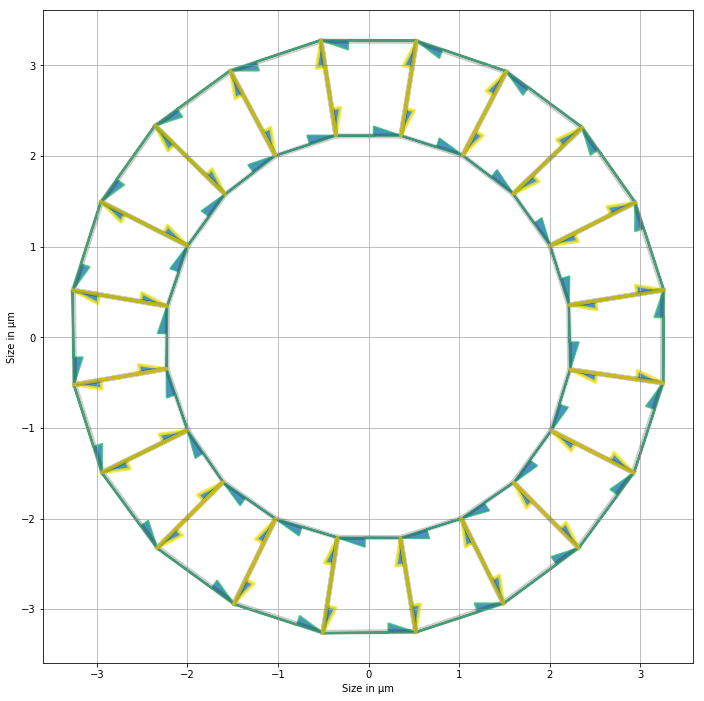

In [10]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_cste = [4*(organo3.edge_df.line_tension.mean() /
               (organo3.face_df.area_elasticity.mean() *
                organo3.face_df.prefered_area.mean()**1.5))]*organo3.Nf
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = organo3_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

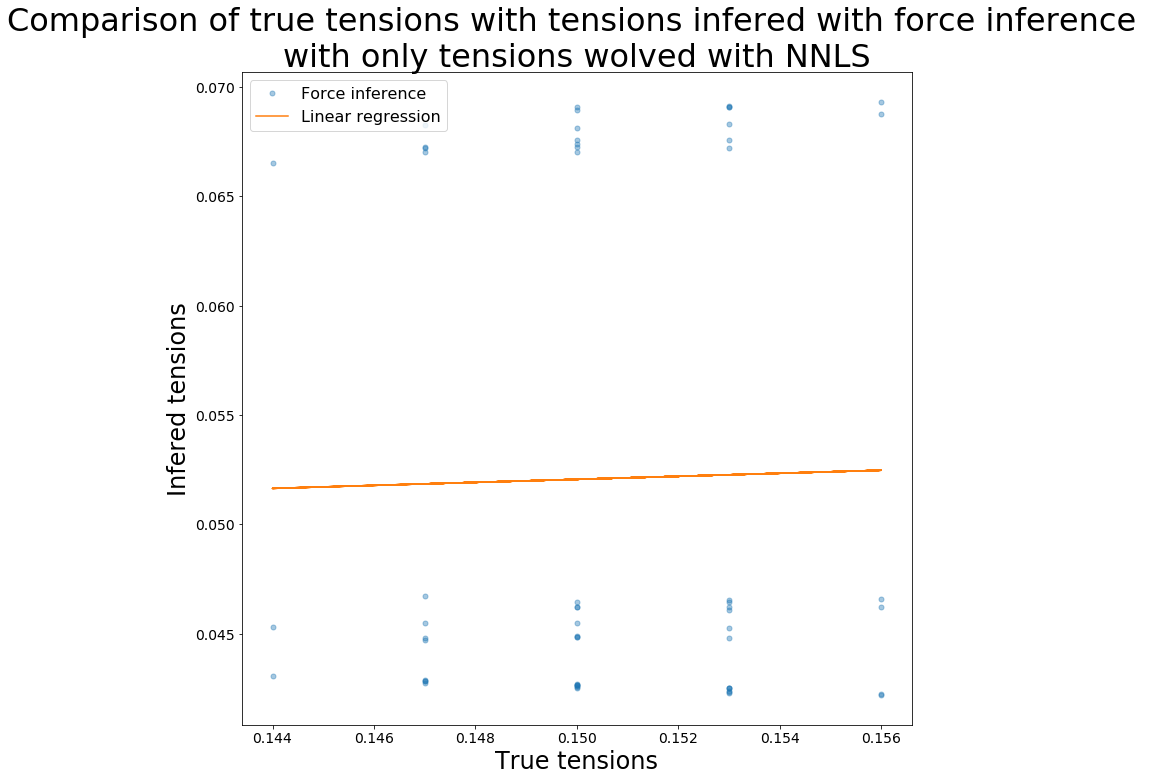

R value : 0.018849974808132094 
Standard error : 0.009821923483488228


In [11]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

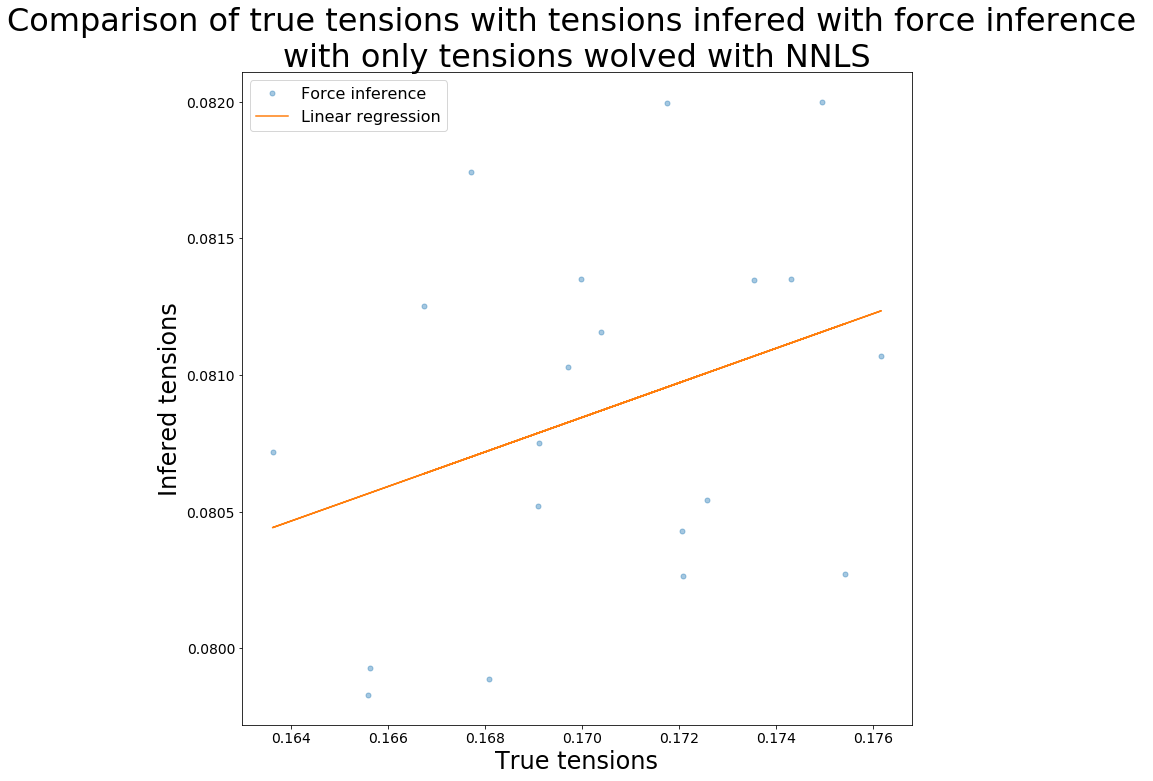

R value : 0.33676027353684546 
Standard error : 0.00030528524743222697


In [12]:
rendering_results(organo3, organo3.face_df.eval('prefered_area-area'),
                  mat_eq_cst[3*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Minimize the distance wrt tensions and areas

In [13]:
iprint_file = "../../assets/dist_at_each_f_ev/4_03_eq_t_per_cell_areas_opt.txt"
to_opt_organo = organo3.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo3.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo3.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    energy_min_opt=energy_opt,
                                    **lm_opt)

0.36257620000102053 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257620005873453 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3625761997009622 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3625762000187531 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36257619986420747 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3625762000227331 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36257620005429925 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257619971777005 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257619916891654 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257619928640356 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3625761990792299 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36257620000102053 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257620000102053 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257620000102053 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560781 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257621350613234 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560782 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201728 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.36257621355653946 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754303 0.00451879 0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560782 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.01192441 0.01287917 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3625762142861471 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606661 0.00560782 0.00677926 0.00543117
 0.00646262 0.00534956 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200012 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.36257621468657725 [0.0064111  0.00624514 0.00696852 0.00525394 0.00626776 0.00534522
 0.00639198 0.00754304 0.0045188  0.00724396 0.00597694 0.00608465
 0.00542049 0.00720804 0.00606662 0.00560782 0.00677926 0.00543117
 0.00646262 0.00534955 0.01205475 0.01273421 0.01201727 0.01251342
 0.0111363  0.01196524 0.01234395 0.0119244  0.01287916 0.01118715
 0.01259511 0.0114464  0.01183384 0.01152405 0.01239824 0.01223094
 0.01166981 0.01247611 0.01106912 0.01200013 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131570856181467 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131570868682894 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3013157087356417 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3013157085133253 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.30131570858128165 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.301315708324706 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.3013157084928208 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.3013157078478965 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.30131570775094046 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.0094322  0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131570775336614 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.0094322  0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131570867548535 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131570867548535 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131570867548535 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131570867548535 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669974 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.30131572486381747 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644002 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669975 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850284 0.00917008 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.3013157231594643 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575285
 0.00559532 0.00623475 0.00669975 0.00630185 0.00650637 0.00599662
 0.00555347 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853643 0.00844035 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868996 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.30131572416669067 [0.00617968 0.00685054 0.00674455 0.00597965 0.00552968 0.00562978
 0.00644003 0.00700312 0.00585219 0.00621179 0.00659604 0.00575286
 0.00559532 0.00623475 0.00669975 0.00630185 0.00650637 0.00599662
 0.00555346 0.00560091 0.00914391 0.00931013 0.00943221 0.00865096
 0.00865914 0.00850283 0.00917007 0.00978519 0.00823613 0.00912206
 0.00899415 0.00853642 0.00844034 0.00930773 0.00901825 0.00867881
 0.00920171 0.00868997 0.00868135 0.00849541 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841437440556 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841269669692 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2049184121861329 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2049184143908938 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.20491841174906023 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841497314517 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357043 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.2049184118372792 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.2049184132116813 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.20491841294046553 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841218574475 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841337122466 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841337122466 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841337122466 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491841337122466 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491842589298448 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.0060624
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.20491842716086534 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579635 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357043 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345857 0.00293151 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.20491842629774865 [0.0064177  0.00687985 0.00706861 0.00599798 0.00593591 0.00606241
 0.00674536 0.00697578 0.00619892 0.00793798 0.0078326  0.00644167
 0.00572775 0.00696666 0.00710248 0.00633767 0.00659793 0.00618051
 0.00579634 0.00597442 0.00407375 0.00419287 0.00412854 0.00362188
 0.00288228 0.00280667 0.00405632 0.00418118 0.00390857 0.00442322
 0.00477485 0.00357042 0.00283199 0.00415434 0.00389891 0.00343708
 0.00354344 0.00345858 0.00293152 0.00286351 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.

0.17778773268751602 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.1777877324652577 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.17778773208129622 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773254887112 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773139066356 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773259148067 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.1777877322118795 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540407 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.1777877313826805 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634628 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

0.17778773140981843 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634628 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773148283494 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634628 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773242449533 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773242449533 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773242449533 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778773242449533 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540406 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778775170522737 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532761 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540407 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263084 0.00243407 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778774089379792 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635974 0.00570563
 0.00540407 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.0030193  0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.17778774719425391 [0.00599761 0.00674548 0.00684191 0.00555436 0.00532762 0.0055097
 0.00636333 0.00677216 0.00598384 0.00646428 0.00649546 0.00588277
 0.00538158 0.00614665 0.00660882 0.00634629 0.00635973 0.00570563
 0.00540407 0.00547136 0.00290181 0.00337363 0.0032971  0.00258308
 0.00263083 0.00243406 0.00284266 0.00402283 0.00180644 0.00283571
 0.00301929 0.00231963 0.00270951 0.00327312 0.00314936 0.00244233
 0.00329094 0.00252061 0.00267271 0.00229944 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

0.11675378093501648 [5.74755257e-03 5.79122712e-03 5.76475677e-03 5.63850283e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871324e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015018e-04 1.06144401e-04 1.01515553e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062796e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378095433608 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850283e-03
 5.47937569e-03 5.56534219e-03 5.79518086e-03 5.78871324e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032394e-05 2.15105382e-04 1.52321692e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378095055888 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850283e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871324e-03
 5.70553620e-03 5.73322257e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190153e-05
 3.33006497e-04 2.59059249e-04 1.06859274e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378098162084 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850283e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871324e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531866e-03 5.65396591e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178660e-04
 1.44175734e-04 1.93261094e-04 1.12849067e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378095688671 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850283e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871324e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471832e-03
 5.75986787e-03 5.62830102e-03 5.47720871e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289462e-04
 1.14676858e-04 1.80354443e-04 1.11545031e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378117341546 [5.74755259e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015134e-04 1.06144496e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062793e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378091763075 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850283e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313561e-04
 7.62032546e-05 2.15105308e-04 1.52321689e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378114517784 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871324e-03
 5.70553621e-03 5.73322258e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190128e-05
 3.33006550e-04 2.59059378e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378079790014 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531867e-03 5.65396593e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178658e-04
 1.44175699e-04 1.93260942e-04 1.12849064e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378100641444 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471832e-03
 5.75986789e-03 5.62830104e-03 5.47720871e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289460e-04
 1.14676796e-04 1.80354537e-04 1.11545029e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378143825065 [5.74755303e-03 5.79122713e-03 5.76475676e-03 5.63850281e-03
 5.47937570e-03 5.56534220e-03 5.79518085e-03 5.78871322e-03
 5.70553621e-03 5.73322258e-03 5.65962025e-03 5.60663288e-03
 5.51531867e-03 5.65396593e-03 5.79612007e-03 5.83471830e-03
 5.75986788e-03 5.62830103e-03 5.47720869e-03 5.51846097e-03
 2.15015356e-04 1.06144381e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190090e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062765e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378157632463 [5.74755258e-03 5.79122714e-03 5.76475676e-03 5.63850280e-03
 5.47937614e-03 5.56534218e-03 5.79518085e-03 5.78871322e-03
 5.70553621e-03 5.73322258e-03 5.65962025e-03 5.60663288e-03
 5.51531867e-03 5.65396593e-03 5.79612007e-03 5.83471830e-03
 5.75986788e-03 5.62830103e-03 5.47720869e-03 5.51846099e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62036687e-05 2.15105373e-04 1.52321687e-04 2.62190090e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378152852997 [5.74755258e-03 5.79122714e-03 5.76475676e-03 5.63850281e-03
 5.47937570e-03 5.56534220e-03 5.79518085e-03 5.78871321e-03
 5.70553665e-03 5.73322256e-03 5.65962025e-03 5.60663288e-03
 5.51531867e-03 5.65396593e-03 5.79612007e-03 5.83471830e-03
 5.75986789e-03 5.62830103e-03 5.47720869e-03 5.51846099e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62189818e-05
 3.33006922e-04 2.59059231e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378154461868 [5.74755258e-03 5.79122714e-03 5.76475676e-03 5.63850281e-03
 5.47937570e-03 5.56534220e-03 5.79518085e-03 5.78871322e-03
 5.70553621e-03 5.73322258e-03 5.65962025e-03 5.60663286e-03
 5.51531910e-03 5.65396591e-03 5.79612007e-03 5.83471830e-03
 5.75986789e-03 5.62830103e-03 5.47720869e-03 5.51846099e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190090e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178638e-04
 1.44176125e-04 1.93261099e-04 1.12849062e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378148008657 [5.74755258e-03 5.79122714e-03 5.76475676e-03 5.63850281e-03
 5.47937570e-03 5.56534220e-03 5.79518085e-03 5.78871322e-03
 5.70553621e-03 5.73322258e-03 5.65962025e-03 5.60663288e-03
 5.51531867e-03 5.65396593e-03 5.79612007e-03 5.83471829e-03
 5.75986833e-03 5.62830102e-03 5.47720869e-03 5.51846099e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190090e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849062e-04 2.35289435e-04
 1.14677223e-04 1.80354423e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378097920885 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378097920885 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378097920885 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378097920885 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675378097920885 [5.74755260e-03 5.79122715e-03 5.76475677e-03 5.63850282e-03
 5.47937571e-03 5.56534221e-03 5.79518086e-03 5.78871323e-03
 5.70553622e-03 5.73322259e-03 5.65962026e-03 5.60663289e-03
 5.51531868e-03 5.65396594e-03 5.79612008e-03 5.83471831e-03
 5.75986790e-03 5.62830105e-03 5.47720870e-03 5.51846100e-03
 2.15015027e-04 1.06144409e-04 1.01515552e-04 2.61313562e-04
 7.62032423e-05 2.15105378e-04 1.52321687e-04 2.62190089e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175733e-04 1.93261084e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675377289421816 [5.74755097e-03 5.79122554e-03 5.76475687e-03 5.63850294e-03
 5.47937583e-03 5.56534233e-03 5.79518098e-03 5.78871335e-03
 5.70553633e-03 5.73322270e-03 5.65962038e-03 5.60663300e-03
 5.51531879e-03 5.65396605e-03 5.79612020e-03 5.83471843e-03
 5.75986801e-03 5.62830116e-03 5.47720882e-03 5.51846110e-03
 2.15011605e-04 1.06141005e-04 1.01515546e-04 2.61313563e-04
 7.62032416e-05 2.15105378e-04 1.52321686e-04 2.62190082e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178655e-04
 1.44175732e-04 1.93261085e-04 1.12849061e-04 2.35289457e-04
 1.14676854e-04 1.80354451e-04 1.11545025e-04 1.48062729e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675377644027427 [5.74755271e-03 5.79122727e-03 5.76475689e-03 5.63850292e-03
 5.47937408e-03 5.56534060e-03 5.79518096e-03 5.78871335e-03
 5.70553634e-03 5.73322271e-03 5.65962038e-03 5.60663301e-03
 5.51531880e-03 5.65396606e-03 5.79612020e-03 5.83471843e-03
 5.75986802e-03 5.62830116e-03 5.47720882e-03 5.51846112e-03
 2.15015028e-04 1.06144408e-04 1.01515551e-04 2.61313574e-04
 7.62006833e-05 2.15104604e-04 1.52321628e-04 2.62190080e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178655e-04
 1.44175732e-04 1.93261085e-04 1.12849061e-04 2.35289457e-04
 1.14676854e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675377290109454 [5.74755271e-03 5.79122726e-03 5.76475688e-03 5.63850294e-03
 5.47937582e-03 5.56534232e-03 5.79518097e-03 5.78871333e-03
 5.70553447e-03 5.73322083e-03 5.65962035e-03 5.60663300e-03
 5.51531879e-03 5.65396605e-03 5.79612019e-03 5.83471843e-03
 5.75986801e-03 5.62830116e-03 5.47720881e-03 5.51846111e-03
 2.15015028e-04 1.06144409e-04 1.01515552e-04 2.61313563e-04
 7.62032421e-05 2.15105379e-04 1.52321687e-04 2.62189311e-05
 3.33003473e-04 2.59055809e-04 1.06859277e-04 2.01178656e-04
 1.44175733e-04 1.93261085e-04 1.12849061e-04 2.35289457e-04
 1.14676855e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675377968337443 [5.74755271e-03 5.79122727e-03 5.76475688e-03 5.63850294e-03
 5.47937583e-03 5.56534233e-03 5.79518098e-03 5.78871335e-03
 5.70553634e-03 5.73322271e-03 5.65962038e-03 5.60663298e-03
 5.51531694e-03 5.65396418e-03 5.79612018e-03 5.83471843e-03
 5.75986801e-03 5.62830116e-03 5.47720882e-03 5.51846112e-03
 2.15015028e-04 1.06144409e-04 1.01515551e-04 2.61313563e-04
 7.62032417e-05 2.15105379e-04 1.52321686e-04 2.62190082e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178603e-04
 1.44174075e-04 1.93263004e-04 1.12848998e-04 2.35289457e-04
 1.14676854e-04 1.80354451e-04 1.11545025e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675377501481918 [5.74755271e-03 5.79122727e-03 5.76475688e-03 5.63850294e-03
 5.47937583e-03 5.56534233e-03 5.79518098e-03 5.78871335e-03
 5.70553633e-03 5.73322270e-03 5.65962038e-03 5.60663300e-03
 5.51531879e-03 5.65396605e-03 5.79612020e-03 5.83471841e-03
 5.75986623e-03 5.62829937e-03 5.47720879e-03 5.51846111e-03
 2.15015028e-04 1.06144409e-04 1.01515551e-04 2.61313563e-04
 7.62032417e-05 2.15105378e-04 1.52321686e-04 2.62190082e-05
 3.33006502e-04 2.59059259e-04 1.06859273e-04 2.01178656e-04
 1.44175732e-04 1.93261085e-04 1.12849061e-04 2.35289403e-04
 1.14675756e-04 1.80351015e-04 1.11544950e-04 1.48062790e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11675404314963016 [5.74756769e-03 5.79124216e-03 5.76477173e-03 5.63851785e-03
 5.47939065e-03 5.56535724e-03 5.79519599e-03 5.78872812e-03
 5.70555130e-03 5.73323760e-03 5.65963516e-03 5.60664790e-03
 5.51533366e-03 5.65398089e-03 5.79613519e-03 5.83473354e-03
 5.75988294e-03 5.62831602e-03 5.47722355e-03 5.51847597e-03
 2.15013343e-04 1.06142457e-04 1.01513731e-04 2.61312126e-04
 7.62010177e-05 2.15103550e-04 1.52319384e-04 2.62170877e-05
 3.33004310e-04 2.59057686e-04 1.06857644e-04 2.01176451e-04
 1.44173639e-04 1.93260782e-04 1.12846707e-04 2.35287094e-04
 1.14674890e-04 1.80352515e-04 1.11542970e-04 1.48060620e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573690765634 [5.67144280e-03 5.71493585e-03 5.68850624e-03 5.56507108e-03
 5.42101477e-03 5.49806235e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598840e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668478e-03 5.55658218e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352548e-05 6.98294117e-05 2.00192243e-04
 2.22311504e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168962e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573694780557 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806235e-03 5.72000718e-03 5.71428509e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598840e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623234e-03
 5.68668478e-03 5.55658218e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923914e-04 3.42838832e-05 9.51630154e-05
 2.08585046e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168962e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573693338042 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806235e-03 5.72000721e-03 5.71428512e-03
 5.62296407e-03 5.65369069e-03 5.58838050e-03 5.53598837e-03
 5.45270226e-03 5.58544982e-03 5.72392144e-03 5.75623234e-03
 5.68668478e-03 5.55658218e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461023e-04 8.00610545e-05 9.17920858e-05
 5.80758900e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573696252651 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806235e-03 5.72000721e-03 5.71428512e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598840e-03
 5.45270225e-03 5.58544982e-03 5.72392142e-03 5.75623231e-03
 5.68668478e-03 5.55658218e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813846e-04 3.30169922e-06 1.12604856e-04
 6.28206482e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573694658122 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806235e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598840e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623234e-03
 5.68668478e-03 5.55658218e-03 5.41401600e-03 5.45432277e-03
 1.47556549e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168962e-06 1.12604859e-04
 6.28206455e-05 9.82337943e-05 3.43439585e-05 5.00669000e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139857372081963 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352571e-05 6.98295277e-05 2.00192393e-04
 2.22311526e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168962e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11398573696998265 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806235e-03 5.72000720e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923912e-04 3.42839287e-05 9.51629736e-05
 2.08585044e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168962e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573715683608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369069e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461023e-04 8.00611849e-05 9.17921642e-05
 5.80758878e-05 2.03813844e-04 3.30168962e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573687145294 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392143e-03 5.75623233e-03
 5.68668478e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813846e-04 3.30158384e-06 1.12604875e-04
 6.28206476e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573673833183 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658218e-03 5.41401602e-03 5.45432279e-03
 1.47556550e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168962e-06 1.12604859e-04
 6.28206455e-05 9.82337944e-05 3.43438034e-05 5.00668210e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573691728484 [5.67144279e-03 5.71493582e-03 5.68850671e-03 5.56507108e-03
 5.42101476e-03 5.49806233e-03 5.72000719e-03 5.71428510e-03
 5.62296405e-03 5.65369067e-03 5.58838051e-03 5.53598838e-03
 5.45270224e-03 5.58544981e-03 5.72392142e-03 5.75623232e-03
 5.68668476e-03 5.55658216e-03 5.41401601e-03 5.45432279e-03
 1.47556552e-04 6.21352862e-05 6.98291841e-05 2.00192230e-04
 2.22311548e-05 1.37923908e-04 3.42838880e-05 9.51630106e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168957e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573757376754 [5.67144279e-03 5.71493584e-03 5.68850626e-03 5.56507109e-03
 5.42101476e-03 5.49806232e-03 5.72000765e-03 5.71428509e-03
 5.62296405e-03 5.65369067e-03 5.58838051e-03 5.53598838e-03
 5.45270224e-03 5.58544981e-03 5.72392142e-03 5.75623232e-03
 5.68668476e-03 5.55658216e-03 5.41401601e-03 5.45432279e-03
 1.47556552e-04 6.21352606e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923881e-04 3.42843196e-05 9.51630351e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168957e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573693394701 [5.67144279e-03 5.71493584e-03 5.68850626e-03 5.56507109e-03
 5.42101476e-03 5.49806233e-03 5.72000720e-03 5.71428510e-03
 5.62296405e-03 5.65369066e-03 5.58838095e-03 5.53598837e-03
 5.45270224e-03 5.58544981e-03 5.72392142e-03 5.75623232e-03
 5.68668476e-03 5.55658216e-03 5.41401601e-03 5.45432279e-03
 1.47556552e-04 6.21352606e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838880e-05 9.51630106e-05
 2.08585042e-04 1.88461036e-04 8.00608658e-05 9.17920668e-05
 5.80758835e-05 2.03813844e-04 3.30168957e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573678439325 [5.67144279e-03 5.71493584e-03 5.68850626e-03 5.56507109e-03
 5.42101476e-03 5.49806233e-03 5.72000719e-03 5.71428510e-03
 5.62296405e-03 5.65369067e-03 5.58838051e-03 5.53598838e-03
 5.45270224e-03 5.58544979e-03 5.72392187e-03 5.75623231e-03
 5.68668476e-03 5.55658216e-03 5.41401601e-03 5.45432279e-03
 1.47556552e-04 6.21352606e-05 6.98294181e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838880e-05 9.51630106e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813836e-04 3.30136355e-06 1.12604837e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668961e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573716610019 [5.67144279e-03 5.71493584e-03 5.68850626e-03 5.56507109e-03
 5.42101476e-03 5.49806233e-03 5.72000720e-03 5.71428510e-03
 5.62296405e-03 5.65369067e-03 5.58838051e-03 5.53598838e-03
 5.45270224e-03 5.58544981e-03 5.72392142e-03 5.75623232e-03
 5.68668476e-03 5.55658215e-03 5.41401645e-03 5.45432277e-03
 1.47556552e-04 6.21352606e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838880e-05 9.51630106e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168957e-06 1.12604859e-04
 6.28206455e-05 9.82338031e-05 3.43439676e-05 5.00668913e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11398573265868533 [5.67144291e-03 5.71493595e-03 5.68850467e-03 5.56506947e-03
 5.42101487e-03 5.49806246e-03 5.72000732e-03 5.71428523e-03
 5.62296418e-03 5.65369080e-03 5.58838063e-03 5.53598851e-03
 5.45270237e-03 5.58544993e-03 5.72392155e-03 5.75623245e-03
 5.68668489e-03 5.55658229e-03 5.41401614e-03 5.45432291e-03
 1.47556552e-04 6.21353292e-05 6.98289928e-05 2.00189441e-04
 2.22312025e-05 1.37923908e-04 3.42838871e-05 9.51630121e-05
 2.08585042e-04 1.88461026e-04 8.00610632e-05 9.17920924e-05
 5.80758833e-05 2.03813846e-04 3.30169043e-06 1.12604859e-04
 6.28206461e-05 9.82337961e-05 3.43439482e-05 5.00668955e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139857356042206 [5.67144292e-03 5.71493597e-03 5.68850639e-03 5.56507122e-03
 5.42101489e-03 5.49806244e-03 5.72000554e-03 5.71428343e-03
 5.62296417e-03 5.65369080e-03 5.58838064e-03 5.53598851e-03
 5.45270237e-03 5.58544994e-03 5.72392156e-03 5.75623246e-03
 5.68668489e-03 5.55658229e-03 5.41401614e-03 5.45432291e-03
 1.47556552e-04 6.21352615e-05 6.98294192e-05 2.00192255e-04
 2.22311560e-05 1.37923832e-04 3.42808845e-05 9.51660058e-05
 2.08585011e-04 1.88461026e-04 8.00610633e-05 9.17920923e-05
 5.80758832e-05 2.03813846e-04 3.30169055e-06 1.12604859e-04
 6.28206462e-05 9.82337961e-05 3.43439482e-05 5.00668954e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11398573138249317 [5.67144292e-03 5.71493597e-03 5.68850639e-03 5.56507122e-03
 5.42101489e-03 5.49806246e-03 5.72000733e-03 5.71428523e-03
 5.62296418e-03 5.65369078e-03 5.58837880e-03 5.53598667e-03
 5.45270234e-03 5.58544994e-03 5.72392156e-03 5.75623245e-03
 5.68668489e-03 5.55658229e-03 5.41401614e-03 5.45432291e-03
 1.47556552e-04 6.21352614e-05 6.98294190e-05 2.00192254e-04
 2.22311557e-05 1.37923908e-04 3.42838872e-05 9.51630120e-05
 2.08585042e-04 1.88461071e-04 8.00602371e-05 9.17887632e-05
 5.80757882e-05 2.03813846e-04 3.30169032e-06 1.12604859e-04
 6.28206461e-05 9.82337962e-05 3.43439482e-05 5.00668956e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573624885258 [5.67144292e-03 5.71493598e-03 5.68850639e-03 5.56507123e-03
 5.42101489e-03 5.49806247e-03 5.72000733e-03 5.71428524e-03
 5.62296419e-03 5.65369081e-03 5.58838064e-03 5.53598852e-03
 5.45270238e-03 5.58544992e-03 5.72391956e-03 5.75623049e-03
 5.68668488e-03 5.55658230e-03 5.41401615e-03 5.45432292e-03
 1.47556552e-04 6.21352614e-05 6.98294190e-05 2.00192254e-04
 2.22311558e-05 1.37923908e-04 3.42838872e-05 9.51630121e-05
 2.08585042e-04 1.88461026e-04 8.00610632e-05 9.17920924e-05
 5.80758833e-05 2.03813810e-04 3.30531425e-06 1.12602108e-04
 6.28206025e-05 9.82337962e-05 3.43439482e-05 5.00668955e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398573736694316 [5.67144289e-03 5.71493597e-03 5.68850639e-03 5.56507122e-03
 5.42101489e-03 5.49806246e-03 5.72000733e-03 5.71428523e-03
 5.62296418e-03 5.65369080e-03 5.58838064e-03 5.53598851e-03
 5.45270237e-03 5.58544994e-03 5.72392155e-03 5.75623245e-03
 5.68668489e-03 5.55658227e-03 5.41401442e-03 5.45432121e-03
 1.47556598e-04 6.21352616e-05 6.98294192e-05 2.00192255e-04
 2.22311561e-05 1.37923908e-04 3.42838869e-05 9.51630124e-05
 2.08585042e-04 1.88461026e-04 8.00610634e-05 9.17920922e-05
 5.80758832e-05 2.03813846e-04 3.30169062e-06 1.12604859e-04
 6.28206462e-05 9.82338299e-05 3.43460578e-05 5.00662364e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139862209479004 [5.67168816e-03 5.71519962e-03 5.68847330e-03 5.56506348e-03
 5.42100715e-03 5.49805468e-03 5.71999956e-03 5.71427764e-03
 5.62295643e-03 5.65368310e-03 5.58837300e-03 5.53598077e-03
 5.45269462e-03 5.58544225e-03 5.72391379e-03 5.75622462e-03
 5.68667718e-03 5.55657459e-03 5.41400848e-03 5.45428883e-03
 1.47655641e-04 6.22034919e-05 6.98870101e-05 2.00192312e-04
 2.22312141e-05 1.37923931e-04 3.42838459e-05 9.51630985e-05
 2.08585065e-04 1.88461076e-04 8.00611139e-05 9.17920765e-05
 5.80758763e-05 2.03813940e-04 3.30173494e-06 1.12604842e-04
 6.28206833e-05 9.82338086e-05 3.43439567e-05 5.00049570e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11398630708193863 [5.67143512e-03 5.71490285e-03 5.68877893e-03 5.56529584e-03
 5.42098174e-03 5.49805466e-03 5.71999952e-03 5.71427760e-03
 5.62295639e-03 5.65368307e-03 5.58837297e-03 5.53598074e-03
 5.45269459e-03 5.58544222e-03 5.72391376e-03 5.75622458e-03
 5.68667714e-03 5.55657456e-03 5.41400845e-03 5.45431515e-03
 1.47556590e-04 6.21910409e-05 6.98917949e-05 2.00291963e-04
 2.22738807e-05 1.37923936e-04 3.42838664e-05 9.51630725e-05
 2.08585077e-04 1.88461074e-04 8.00611011e-05 9.17920924e-05
 5.80758851e-05 2.03813922e-04 3.30171688e-06 1.12604861e-04
 6.28206743e-05 9.82338134e-05 3.43439567e-05 5.00668869e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398589380220193 [5.67143478e-03 5.71492790e-03 5.68849835e-03 5.56503727e-03
 5.42125900e-03 5.49829911e-03 5.71997295e-03 5.71427725e-03
 5.62295606e-03 5.65368273e-03 5.58837263e-03 5.53598042e-03
 5.45269427e-03 5.58544189e-03 5.72391341e-03 5.75622423e-03
 5.68667680e-03 5.55657423e-03 5.41400814e-03 5.45431483e-03
 1.47556565e-04 6.21353000e-05 6.98294635e-05 2.00218644e-04
 2.21916454e-05 1.37849194e-04 3.42428326e-05 9.51630879e-05
 2.08585026e-04 1.88461043e-04 8.00611029e-05 9.17920567e-05
 5.80758640e-05 2.03813908e-04 3.30173867e-06 1.12604818e-04
 6.28206744e-05 9.82337903e-05 3.43439507e-05 5.00668598e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398592125535498 [5.67143382e-03 5.71492694e-03 5.68849740e-03 5.56506216e-03
 5.42100586e-03 5.49802672e-03 5.72024005e-03 5.71453920e-03
 5.62293076e-03 5.65368177e-03 5.58837168e-03 5.53597946e-03
 5.45269332e-03 5.58544093e-03 5.72391244e-03 5.75622326e-03
 5.68667583e-03 5.55657327e-03 5.41400719e-03 5.45431388e-03
 1.47556566e-04 6.21352933e-05 6.98294558e-05 2.00192277e-04
 2.22312035e-05 1.37865384e-04 3.43281926e-05 9.51195238e-05
 2.08551588e-04 1.88461043e-04 8.00610963e-05 9.17920660e-05
 5.80758692e-05 2.03813900e-04 3.30172878e-06 1.12604829e-04
 6.28206698e-05 9.82337935e-05 3.43439509e-05 5.00668682e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.113986193459541 [5.67143440e-03 5.71492751e-03 5.68849796e-03 5.56506275e-03
 5.42100646e-03 5.49805398e-03 5.71999878e-03 5.71425258e-03
 5.62314822e-03 5.65390418e-03 5.58834806e-03 5.53598005e-03
 5.45269392e-03 5.58544151e-03 5.72391302e-03 5.75622384e-03
 5.68667641e-03 5.55657386e-03 5.41400778e-03 5.45431447e-03
 1.47556566e-04 6.21352439e-05 6.98293986e-05 2.00192269e-04
 2.22311175e-05 1.37923931e-04 3.42839290e-05 9.52036526e-05
 2.08642476e-04 1.88562985e-04 8.01183809e-05 9.17921316e-05
 5.80759058e-05 2.03813833e-04 3.30165699e-06 1.12604905e-04
 6.28206360e-05 9.82338154e-05 3.43439518e-05 5.00669283e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.11398605945380433 [5.67143422e-03 5.71492733e-03 5.68849779e-03 5.56506257e-03
 5.42100629e-03 5.49805380e-03 5.71999861e-03 5.71427668e-03
 5.62295551e-03 5.65365795e-03 5.58860232e-03 5.53618735e-03
 5.45266874e-03 5.58544133e-03 5.72391284e-03 5.75622367e-03
 5.68667623e-03 5.55657368e-03 5.41400761e-03 5.45431430e-03
 1.47556563e-04 6.21352501e-05 6.98294058e-05 2.00192267e-04
 2.22311298e-05 1.37923925e-04 3.42839163e-05 9.51629867e-05
 2.08585075e-04 1.88485812e-04 8.01362234e-05 9.18580055e-05
 5.80143713e-05 2.03813839e-04 3.30166747e-06 1.12604892e-04
 6.28206399e-05 9.82338105e-05 3.43439511e-05 5.00669186e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398571626960516 [5.67143298e-03 5.71492608e-03 5.68849654e-03 5.56506135e-03
 5.42100509e-03 5.49805259e-03 5.71999736e-03 5.71427543e-03
 5.62295427e-03 5.65368093e-03 5.58837085e-03 5.53595330e-03
 5.45289295e-03 5.58566052e-03 5.72388778e-03 5.75622241e-03
 5.68667499e-03 5.55657246e-03 5.41400642e-03 5.45431310e-03
 1.47556533e-04 6.21352448e-05 6.98294000e-05 2.00192227e-04
 2.22311378e-05 1.37923894e-04 3.42838973e-05 9.51629821e-05
 2.08585025e-04 1.88461002e-04 8.00610443e-05 9.17628440e-05
 5.80037290e-05 2.03707612e-04 3.31216343e-06 1.12604858e-04
 6.28206320e-05 9.82337874e-05 3.43439439e-05 5.00668997e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398578392295014 [5.67143287e-03 5.71492598e-03 5.68849644e-03 5.56506125e-03
 5.42100499e-03 5.49805249e-03 5.71999725e-03 5.71427533e-03
 5.62295417e-03 5.65368083e-03 5.58837075e-03 5.53597856e-03
 5.45269244e-03 5.58541535e-03 5.72410145e-03 5.75642912e-03
 5.68664877e-03 5.55657236e-03 5.41400632e-03 5.45431300e-03
 1.47556537e-04 6.21352349e-05 6.98293886e-05 2.00192231e-04
 2.22311183e-05 1.37923903e-04 3.42839174e-05 9.51629612e-05
 2.08585042e-04 1.88461007e-04 8.00610351e-05 9.17921099e-05
 5.80758924e-05 2.03795618e-04 3.21260091e-06 1.12635446e-04
 6.27955158e-05 9.82337951e-05 3.43439451e-05 5.00669150e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398591203119765 [5.67143417e-03 5.71492729e-03 5.68849775e-03 5.56506252e-03
 5.42100622e-03 5.49805373e-03 5.71999856e-03 5.71427665e-03
 5.62295545e-03 5.65368212e-03 5.58837203e-03 5.53597982e-03
 5.45269368e-03 5.58544128e-03 5.72391280e-03 5.75619902e-03
 5.68692961e-03 5.55680963e-03 5.41398191e-03 5.45431423e-03
 1.47556568e-04 6.21352834e-05 6.98294443e-05 2.00192278e-04
 2.22311851e-05 1.37923916e-04 3.42838650e-05 9.51630536e-05
 2.08585048e-04 1.88461046e-04 8.00610869e-05 9.17920816e-05
 5.80758780e-05 2.03813888e-04 3.30171316e-06 1.12555523e-04
 6.27182875e-05 9.83361944e-05 3.43003323e-05 5.00668821e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398593450472705 [5.67140868e-03 5.71492805e-03 5.68849850e-03 5.56506327e-03
 5.42100696e-03 5.49805448e-03 5.71999933e-03 5.71427740e-03
 5.62295621e-03 5.65368288e-03 5.58837278e-03 5.53598057e-03
 5.45269442e-03 5.58544203e-03 5.72391356e-03 5.75622439e-03
 5.68667695e-03 5.55654918e-03 5.41426139e-03 5.45456113e-03
 1.47582198e-04 6.21352980e-05 6.98294611e-05 2.00192283e-04
 2.22312096e-05 1.37923911e-04 3.42838421e-05 9.51630830e-05
 2.08585036e-04 1.88461048e-04 8.00611014e-05 9.17920640e-05
 5.80758683e-05 2.03813909e-04 3.30173346e-06 1.12604827e-04
 6.28206736e-05 9.82502031e-05 3.42454364e-05 5.00291694e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398350920402707 [5.67147436e-03 5.71496811e-03 5.68848796e-03 5.56507125e-03
 5.42101491e-03 5.49806249e-03 5.72000737e-03 5.71428529e-03
 5.62296422e-03 5.65369084e-03 5.58838068e-03 5.53598854e-03
 5.45270239e-03 5.58544997e-03 5.72392160e-03 5.75623249e-03
 5.68668494e-03 5.55658233e-03 5.41401617e-03 5.45430362e-03
 1.46325028e-04 6.11116384e-05 6.98613358e-05 2.00192254e-04
 2.22312391e-05 1.37923880e-04 3.42838048e-05 9.51631063e-05
 2.08584982e-04 1.88461017e-04 8.00611071e-05 9.17920239e-05
 5.80758448e-05 2.03813901e-04 3.30176059e-06 1.12604780e-04
 6.28206764e-05 9.82337703e-05 3.43439457e-05 5.00335932e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398361704111597 [5.67144269e-03 5.71491703e-03 5.68853748e-03 5.56510295e-03
 5.42099585e-03 5.49806224e-03 5.72000710e-03 5.71428502e-03
 5.62296396e-03 5.65369058e-03 5.58838042e-03 5.53598829e-03
 5.45270214e-03 5.58544972e-03 5.72392133e-03 5.75623223e-03
 5.68668467e-03 5.55658207e-03 5.41401592e-03 5.45432269e-03
 1.47556541e-04 6.21669481e-05 6.88675018e-05 1.98959178e-04
 2.22510731e-05 1.37923880e-04 3.42838209e-05 9.51630824e-05
 2.08584986e-04 1.88461011e-04 8.00610945e-05 9.17920347e-05
 5.80758506e-05 2.03813881e-04 3.30174555e-06 1.12604792e-04
 6.28206674e-05 9.82337717e-05 3.43439448e-05 5.00668453e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398709536085341 [5.67144434e-03 5.71493741e-03 5.68850782e-03 5.56505307e-03
 5.42104855e-03 5.49809526e-03 5.71998944e-03 5.71428668e-03
 5.62296559e-03 5.65369222e-03 5.58838204e-03 5.53598989e-03
 5.45270371e-03 5.58545133e-03 5.72392299e-03 5.75623389e-03
 5.68668632e-03 5.55658368e-03 5.41401748e-03 5.45432426e-03
 1.47556578e-04 6.21353381e-05 6.98295074e-05 2.00211220e-04
 2.25220663e-05 1.38935713e-04 3.42649341e-05 9.51631629e-05
 2.08585009e-04 1.88461059e-04 8.00611420e-05 9.17920208e-05
 5.80758446e-05 2.03813970e-04 3.30178669e-06 1.12604777e-04
 6.28207022e-05 9.82337840e-05 3.43439530e-05 5.00668241e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398574291889332 [5.67144418e-03 5.71493725e-03 5.68850766e-03 5.56507246e-03
 5.42101608e-03 5.49804429e-03 5.72004119e-03 5.71432033e-03
 5.62294760e-03 5.65369207e-03 5.58838189e-03 5.53598974e-03
 5.45270357e-03 5.58545118e-03 5.72392284e-03 5.75623374e-03
 5.68668617e-03 5.55658353e-03 5.41401734e-03 5.45432412e-03
 1.47556577e-04 6.21353211e-05 6.98294878e-05 2.00192297e-04
 2.22312453e-05 1.37890641e-04 3.39397519e-05 9.55032753e-05
 2.08571242e-04 1.88461058e-04 8.00611253e-05 9.17920427e-05
 5.80758568e-05 2.03813947e-04 3.30176239e-06 1.12604803e-04
 6.28206905e-05 9.82337911e-05 3.43439532e-05 5.00668443e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398410921387556 [5.67144330e-03 5.71493636e-03 5.68850678e-03 5.56507160e-03
 5.42101525e-03 5.49806283e-03 5.72000772e-03 5.71426733e-03
 5.62300076e-03 5.65372741e-03 5.58836267e-03 5.53598889e-03
 5.45270273e-03 5.58545032e-03 5.72392195e-03 5.75623285e-03
 5.68668528e-03 5.55658267e-03 5.41401651e-03 5.45432328e-03
 1.47556563e-04 6.21352765e-05 6.98294364e-05 2.00192270e-04
 2.22311762e-05 1.37923913e-04 3.42838715e-05 9.51818929e-05
 2.08081137e-04 1.87239163e-04 8.00943604e-05 9.17920845e-05
 5.80758794e-05 2.03813874e-04 3.30170630e-06 1.12604850e-04
 6.28206579e-05 9.82337982e-05 3.43439504e-05 5.00668859e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398415620606253 [5.67144391e-03 5.71493697e-03 5.68850738e-03 5.56507219e-03
 5.42101582e-03 5.49806341e-03 5.72000833e-03 5.71428624e-03
 5.62296516e-03 5.65367386e-03 5.58841768e-03 5.53602433e-03
 5.45268425e-03 5.58545091e-03 5.72392256e-03 5.75623346e-03
 5.68668589e-03 5.55658326e-03 5.41401708e-03 5.45432386e-03
 1.47556576e-04 6.21352938e-05 6.98294562e-05 2.00192290e-04
 2.22311986e-05 1.37923920e-04 3.42838550e-05 9.51630732e-05
 2.08585052e-04 1.88478722e-04 7.90356423e-05 9.11988440e-05
 5.80399584e-05 2.03813909e-04 3.30172360e-06 1.12604842e-04
 6.28206716e-05 9.82338019e-05 3.43439533e-05 5.00668762e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398796042252489 [5.67144563e-03 5.71493871e-03 5.68850911e-03 5.56507388e-03
 5.42101747e-03 5.49806508e-03 5.72001006e-03 5.71428798e-03
 5.62296687e-03 5.65369351e-03 5.58838331e-03 5.53597208e-03
 5.45274066e-03 5.58548941e-03 5.72390650e-03 5.75623521e-03
 5.68668761e-03 5.55658494e-03 5.41401872e-03 5.45432551e-03
 1.47556617e-04 6.21353302e-05 6.98294977e-05 2.00192349e-04
 2.22312381e-05 1.37923950e-04 3.42838326e-05 9.51631386e-05
 2.08585089e-04 1.88461108e-04 8.00611392e-05 9.17798722e-05
 5.90336978e-05 2.04998452e-04 3.30267366e-06 1.12604844e-04
 6.28207022e-05 9.82338206e-05 3.43439625e-05 5.00668668e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398666847444652 [5.67144489e-03 5.71493797e-03 5.68850837e-03 5.56507316e-03
 5.42101677e-03 5.49806437e-03 5.72000932e-03 5.71428723e-03
 5.62296614e-03 5.65369277e-03 5.58838259e-03 5.53599044e-03
 5.45270426e-03 5.58543402e-03 5.72396381e-03 5.75627316e-03
 5.68666791e-03 5.55658423e-03 5.41401802e-03 5.45432481e-03
 1.47556600e-04 6.21353101e-05 6.98294747e-05 2.00192325e-04
 2.22312127e-05 1.37923940e-04 3.42838508e-05 9.51631011e-05
 2.08585080e-04 1.88461087e-04 8.00611173e-05 9.17920845e-05
 5.80758812e-05 2.03799777e-04 4.31250401e-06 1.12473398e-04
 6.28028561e-05 9.82338155e-05 3.43439589e-05 5.00668773e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398578758690452 [5.67144396e-03 5.71493703e-03 5.68850744e-03 5.56507224e-03
 5.42101587e-03 5.49806346e-03 5.72000838e-03 5.71428630e-03
 5.62296522e-03 5.65369185e-03 5.58838167e-03 5.53598952e-03
 5.45270336e-03 5.58545097e-03 5.72392261e-03 5.75621553e-03
 5.68671916e-03 5.55661676e-03 5.41399793e-03 5.45432391e-03
 1.47556572e-04 6.21353146e-05 6.98294803e-05 2.00192290e-04
 2.22312367e-05 1.37923907e-04 3.42838173e-05 9.51631162e-05
 2.08585024e-04 1.88461052e-04 8.00611182e-05 9.17920457e-05
 5.80758582e-05 2.03813934e-04 3.30175570e-06 1.12581475e-04
 6.40468503e-05 9.70562068e-05 3.43165196e-05 5.00668481e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398768163412931 [5.67142444e-03 5.71493706e-03 5.68850747e-03 5.56507226e-03
 5.42101589e-03 5.49806348e-03 5.72000841e-03 5.71428633e-03
 5.62296524e-03 5.65369187e-03 5.58838169e-03 5.53598955e-03
 5.45270338e-03 5.58545099e-03 5.72392264e-03 5.75623354e-03
 5.68668597e-03 5.55656403e-03 5.41404841e-03 5.45435463e-03
 1.47574953e-04 6.21353270e-05 6.98294947e-05 2.00192289e-04
 2.22312595e-05 1.37923899e-04 3.42837946e-05 9.51631419e-05
 2.08585007e-04 1.88461049e-04 8.00611301e-05 9.17920267e-05
 5.80758475e-05 2.03813949e-04 3.30177498e-06 1.12604784e-04
 6.28206936e-05 9.82475173e-05 3.55653058e-05 5.07111207e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398424479831423 [5.66900982e-03 5.71508487e-03 5.68857308e-03 5.56513795e-03
 5.42108103e-03 5.49812915e-03 5.72007484e-03 5.71435168e-03
 5.62303124e-03 5.65375763e-03 5.58844688e-03 5.53605511e-03
 5.45276872e-03 5.58551643e-03 5.72398904e-03 5.75630048e-03
 5.68675197e-03 5.55664878e-03 5.41408183e-03 5.45447888e-03
 1.46862193e-04 6.21689572e-05 6.98297765e-05 2.00192533e-04
 2.22315960e-05 1.37923967e-04 3.42835311e-05 9.51636089e-05
 2.08585038e-04 1.88461250e-04 8.00613920e-05 9.17918856e-05
 5.80757762e-05 2.03814406e-04 3.30203915e-06 1.12604628e-04
 6.28208835e-05 9.82338072e-05 3.43439848e-05 5.02241487e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398604489284 [5.67150961e-03 5.71509006e-03 5.68606920e-03 5.56521920e-03
 5.42108047e-03 5.49812859e-03 5.72007427e-03 5.71435111e-03
 5.62303067e-03 5.65375706e-03 5.58844631e-03 5.53605455e-03
 5.45276816e-03 5.58551587e-03 5.72398847e-03 5.75629990e-03
 5.68675140e-03 5.55664821e-03 5.41408128e-03 5.45438865e-03
 1.47556736e-04 6.19941969e-05 7.11548775e-05 2.00321478e-04
 2.22315306e-05 1.37923992e-04 3.42835973e-05 9.51635368e-05
 2.08585092e-04 1.88461262e-04 8.00613594e-05 9.17919424e-05
 5.80758084e-05 2.03814368e-04 3.30198357e-06 1.12604694e-04
 6.28208612e-05 9.82338305e-05 3.43439877e-05 5.00667160e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0000

0.11398707485275429 [5.67151099e-03 5.71500378e-03 5.68857391e-03 5.56522537e-03
 5.41857679e-03 5.49820868e-03 5.72007567e-03 5.71435253e-03
 5.62303204e-03 5.65375845e-03 5.58844768e-03 5.53605589e-03
 5.45276947e-03 5.58551723e-03 5.72398987e-03 5.75630131e-03
 5.68675279e-03 5.55664956e-03 5.41408258e-03 5.45438996e-03
 1.47556756e-04 6.21356280e-05 6.98298404e-05 2.00127587e-04
 2.46540248e-05 1.37887356e-04 3.42834662e-05 9.51637159e-05
 2.08585035e-04 1.88461289e-04 8.00614506e-05 9.17918472e-05
 5.80757562e-05 2.03814506e-04 3.30210223e-06 1.12604586e-04
 6.28209258e-05 9.82338082e-05 3.43439910e-05 5.00666241e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398237405953943 [5.67151035e-03 5.71500311e-03 5.68857324e-03 5.56513812e-03
 5.42108119e-03 5.49821963e-03 5.71757557e-03 5.71443604e-03
 5.62303140e-03 5.65375780e-03 5.58844704e-03 5.53605528e-03
 5.45276889e-03 5.58551660e-03 5.72398921e-03 5.75630065e-03
 5.68675214e-03 5.55664894e-03 5.41408200e-03 5.45438938e-03
 1.47556728e-04 6.21355651e-05 6.98297680e-05 2.00192534e-04
 2.22315821e-05 1.38072391e-04 3.18896858e-05 9.50274514e-05
 2.08585050e-04 1.88461253e-04 8.00613851e-05 9.17918977e-05
 5.80757831e-05 2.03814398e-04 3.30202735e-06 1.12604642e-04
 6.28208788e-05 9.82338122e-05 3.43439854e-05 5.00666768e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398243360891877 [5.67150926e-03 5.71500201e-03 5.68857214e-03 5.56513705e-03
 5.42108016e-03 5.49812826e-03 5.72007390e-03 5.71443436e-03
 5.62052743e-03 5.65384305e-03 5.58844596e-03 5.53605422e-03
 5.45276785e-03 5.58551552e-03 5.72398810e-03 5.75629954e-03
 5.68675104e-03 5.55664787e-03 5.41408096e-03 5.45438834e-03
 1.47556722e-04 6.21354940e-05 6.98296858e-05 2.00192513e-04
 2.22314620e-05 1.37923997e-04 3.42836579e-05 9.50593185e-05
 2.06263872e-04 1.88594379e-04 8.00613143e-05 9.17919847e-05
 5.80758313e-05 2.03814298e-04 3.30192774e-06 1.12604742e-04
 6.28208292e-05 9.82338383e-05 3.43439852e-05 5.00667579e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398595663005931 [5.67150942e-03 5.71500219e-03 5.68857233e-03 5.56513719e-03
 5.42108027e-03 5.49812838e-03 5.72007408e-03 5.71435093e-03
 5.62303048e-03 5.65383929e-03 5.58594100e-03 5.53613805e-03
 5.45276796e-03 5.58551568e-03 5.72398828e-03 5.75629971e-03
 5.68675121e-03 5.55664802e-03 5.41408108e-03 5.45438845e-03
 1.47556732e-04 6.21355694e-05 6.98297729e-05 2.00192539e-04
 2.22315876e-05 1.37923974e-04 3.42835412e-05 9.51636016e-05
 2.08585052e-04 1.88400416e-04 8.12077308e-05 9.19398931e-05
 5.80757823e-05 2.03814407e-04 3.30203153e-06 1.12604641e-04
 6.28208822e-05 9.82338132e-05 3.43439862e-05 5.00666745e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139834490984615 [5.67151078e-03 5.71500356e-03 5.68857369e-03 5.56513853e-03
 5.42108157e-03 5.49812970e-03 5.72007545e-03 5.71435230e-03
 5.62303182e-03 5.65375823e-03 5.58844747e-03 5.53614005e-03
 5.45026553e-03 5.58560175e-03 5.72398965e-03 5.75630109e-03
 5.68675257e-03 5.55664936e-03 5.41408238e-03 5.45438976e-03
 1.47556750e-04 6.21356107e-05 6.98298204e-05 2.00192569e-04
 2.22316490e-05 1.37923976e-04 3.42834891e-05 9.51636820e-05
 2.08585042e-04 1.88461281e-04 8.00614328e-05 9.18653556e-05
 5.68408977e-05 2.03670272e-04 3.30208088e-06 1.12604603e-04
 6.28209130e-05 9.82338104e-05 3.43439898e-05 5.00666397e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11398700128797411 [5.67151089e-03 5.71500366e-03 5.68857379e-03 5.56513864e-03
 5.42108170e-03 5.49812983e-03 5.72007555e-03 5.71435239e-03
 5.62303194e-03 5.65375834e-03 5.58844757e-03 5.53605580e-03
 5.45276940e-03 5.58560116e-03 5.72149237e-03 5.75639218e-03
 5.68675268e-03 5.55664947e-03 5.41408251e-03 5.45438989e-03
 1.47556737e-04 6.21355959e-05 6.98298035e-05 2.00192550e-04
 2.22316308e-05 1.37923968e-04 3.42835017e-05 9.51636546e-05
 2.08585033e-04 1.88461264e-04 8.00614166e-05 9.17918669e-05
 5.80757663e-05 2.03859320e-04 5.36564554e-06 1.12728434e-04
 6.28209011e-05 9.82338059e-05 3.43439869e-05 5.00666466e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398576533025223 [5.67151017e-03 5.71500294e-03 5.68857307e-03 5.56513793e-03
 5.42108100e-03 5.49812912e-03 5.72007483e-03 5.71435167e-03
 5.62303122e-03 5.65375762e-03 5.58844686e-03 5.53605509e-03
 5.45276870e-03 5.58551642e-03 5.72398903e-03 5.75638522e-03
 5.68425082e-03 5.55673182e-03 5.41408181e-03 5.45438919e-03
 1.47556730e-04 6.21355836e-05 6.98297894e-05 2.00192539e-04
 2.22316134e-05 1.37923966e-04 3.42835158e-05 9.51636311e-05
 2.08585034e-04 1.88461255e-04 8.00614036e-05 9.17918751e-05
 5.80757706e-05 2.03814425e-04 3.30205328e-06 1.12730504e-04
 6.35713450e-05 9.83791347e-05 3.43439855e-05 5.00666557e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398468812135792 [5.67150989e-03 5.71500267e-03 5.68857280e-03 5.56513765e-03
 5.42108071e-03 5.49812883e-03 5.72007455e-03 5.71435141e-03
 5.62303094e-03 5.65375735e-03 5.58844659e-03 5.53605481e-03
 5.45276841e-03 5.58551614e-03 5.72398875e-03 5.75630019e-03
 5.68675168e-03 5.55673300e-03 5.41157427e-03 5.45446599e-03
 1.47556748e-04 6.21355848e-05 6.98297905e-05 2.00192562e-04
 2.22316053e-05 1.37923985e-04 3.42835302e-05 9.51636298e-05
 2.08585065e-04 1.88461278e-04 8.00614070e-05 9.17918942e-05
 5.80757821e-05 2.03814441e-04 3.30204462e-06 1.12604639e-04
 6.28208950e-05 9.81938490e-05 3.43185306e-05 5.00942324e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.1139857369674608 [5.67144280e-03 5.71493585e-03 5.68850627e-03 5.56507110e-03
 5.42101477e-03 5.49806234e-03 5.72000721e-03 5.71428511e-03
 5.62296407e-03 5.65369068e-03 5.58838052e-03 5.53598839e-03
 5.45270225e-03 5.58544982e-03 5.72392144e-03 5.75623233e-03
 5.68668477e-03 5.55658217e-03 5.41401603e-03 5.45432280e-03
 1.47556552e-04 6.21352607e-05 6.98294182e-05 2.00192254e-04
 2.22311548e-05 1.37923908e-04 3.42838879e-05 9.51630107e-05
 2.08585042e-04 1.88461025e-04 8.00610624e-05 9.17920928e-05
 5.80758835e-05 2.03813844e-04 3.30168963e-06 1.12604859e-04
 6.28206455e-05 9.82337961e-05 3.43439481e-05 5.00668960e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11398775211571348 [5.67213365e-03 5.71562381e-03 5.68846228e-03 5.56502093e-03
 5.42096512e-03 5.49801226e-03 5.71995637e-03 5.71423501e-03
 5.62291363e-03 5.65364037e-03 5.58833066e-03 5.53593834e-03
 5.45265243e-03 5.58539979e-03 5.72387062e-03 5.75618112e-03
 5.68663427e-03 5.55653218e-03 5.41396669e-03 5.45428101e-03
 1.48761747e-04 6.24554118e-05 6.98001227e-05 2.00191939e-04
 2.22306649e-05 1.37923839e-04 3.42842829e-05 9.51623447e-05
 2.08585041e-04 1.88460771e-04 8.00606947e-05 9.17923203e-05
 5.80760010e-05 2.03813216e-04 3.30130184e-06 1.12605113e-04
 6.28203800e-05 9.82337812e-05 3.43439065e-05 5.00987028e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398759251299162 [5.67139313e-03 5.71489289e-03 5.68918871e-03 5.56576886e-03
 5.42097457e-03 5.49801320e-03 5.71995733e-03 5.71423596e-03
 5.62291458e-03 5.65364132e-03 5.58833160e-03 5.53593927e-03
 5.45265336e-03 5.58540073e-03 5.72387158e-03 5.75618209e-03
 5.68663522e-03 5.55653311e-03 5.41396761e-03 5.45427394e-03
 1.47556358e-04 6.21060390e-05 7.00259201e-05 2.01394158e-04
 2.22108427e-05 1.37923829e-04 3.42842318e-05 9.51624103e-05
 2.08585013e-04 1.88460775e-04 8.00607273e-05 9.17922812e-05
 5.80759794e-05 2.03813262e-04 3.30134713e-06 1.12605068e-04
 6.28204028e-05 9.82337697e-05 3.43439068e-05 5.00671130e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.1139847154824257 [5.67139175e-03 5.71488494e-03 5.68845558e-03 5.56503084e-03
 5.42170230e-03 5.49873874e-03 5.71996614e-03 5.71423455e-03
 5.62291322e-03 5.65363994e-03 5.58833024e-03 5.53593795e-03
 5.45265206e-03 5.58539938e-03 5.72387019e-03 5.75618070e-03
 5.68663384e-03 5.55653178e-03 5.41396631e-03 5.45427264e-03
 1.47556338e-04 6.21348487e-05 6.98289444e-05 2.00172137e-04
 2.10577964e-05 1.37605769e-04 3.43046720e-05 9.51622163e-05
 2.08585079e-04 1.88460749e-04 8.00606289e-05 9.17923868e-05
 5.80760373e-05 2.03813115e-04 3.30121754e-06 1.12605188e-04
 6.28203333e-05 9.82337957e-05 3.43439037e-05 5.00672143e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

0.11398631991303099 [5.67139270e-03 5.71488591e-03 5.68845654e-03 5.56502145e-03
 5.42096564e-03 5.49802106e-03 5.72070811e-03 5.71498973e-03
 5.62292089e-03 5.65364089e-03 5.58833118e-03 5.53593885e-03
 5.45265295e-03 5.58540031e-03 5.72387115e-03 5.75618166e-03
 5.68663479e-03 5.55653269e-03 5.41396720e-03 5.45427353e-03
 1.47556357e-04 6.21349158e-05 6.98290218e-05 2.00191944e-04
 2.22306675e-05 1.37955840e-04 3.55511911e-05 9.39099105e-05
 2.08598206e-04 1.88460774e-04 8.00606975e-05 9.17923205e-05
 5.80760013e-05 2.03813221e-04 3.30130370e-06 1.12605113e-04
 6.28203820e-05 9.82337825e-05 3.43439072e-05 5.00671492e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398887075234014 [5.67139394e-03 5.71488718e-03 5.68845781e-03 5.56502265e-03
 5.42096678e-03 5.49801394e-03 5.71995816e-03 5.71424526e-03
 5.62369968e-03 5.65442821e-03 5.58834025e-03 5.53594004e-03
 5.45265410e-03 5.58540153e-03 5.72387241e-03 5.75618292e-03
 5.68663605e-03 5.55653390e-03 5.41396835e-03 5.45427468e-03
 1.47556374e-04 6.21350546e-05 6.98291823e-05 2.00191990e-04
 2.22308994e-05 1.37923799e-04 3.42840656e-05 9.51436843e-05
 2.09922507e-04 1.89694225e-04 8.00281127e-05 9.17921562e-05
 5.80759104e-05 2.03813422e-04 3.30149542e-06 1.12604924e-04
 6.28204796e-05 9.82337356e-05 3.43439087e-05 5.00669948e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398807090451842 [5.67139369e-03 5.71488691e-03 5.68845753e-03 5.56502242e-03
 5.42096658e-03 5.49801373e-03 5.71995790e-03 5.71423653e-03
 5.62291513e-03 5.65365061e-03 5.58909676e-03 5.53670634e-03
 5.45266479e-03 5.58540128e-03 5.72387215e-03 5.75618266e-03
 5.68663578e-03 5.55653366e-03 5.41396814e-03 5.45427447e-03
 1.47556359e-04 6.21349838e-05 6.98291004e-05 2.00191958e-04
 2.22307848e-05 1.37923813e-04 3.42841697e-05 9.51624872e-05
 2.08584975e-04 1.88442169e-04 8.04165697e-05 9.31761444e-05
 5.81154534e-05 2.03813314e-04 3.30140143e-06 1.12605011e-04
 6.28204288e-05 9.82337540e-05 3.43439063e-05 5.00670680e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398478062951767 [5.67139288e-03 5.71488608e-03 5.68845671e-03 5.56502163e-03
 5.42096583e-03 5.49801297e-03 5.71995708e-03 5.71423570e-03
 5.62291433e-03 5.65364107e-03 5.58833136e-03 5.53595047e-03
 5.45342222e-03 5.58617629e-03 5.72388005e-03 5.75618184e-03
 5.68663497e-03 5.55653288e-03 5.41396738e-03 5.45427372e-03
 1.47556347e-04 6.21349179e-05 6.98290244e-05 2.00191930e-04
 2.22306774e-05 1.37923828e-04 3.42842679e-05 9.51623557e-05
 2.08585022e-04 1.88460761e-04 8.00606982e-05 9.18067743e-05
 5.78636455e-05 2.02484101e-04 3.30054266e-06 1.12605094e-04
 6.28203820e-05 9.82337724e-05 3.43439045e-05 5.00671374e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11398603420350507 [5.67139175e-03 5.71488498e-03 5.68845562e-03 5.56502049e-03
 5.42096467e-03 5.49801181e-03 5.71995595e-03 5.71423462e-03
 5.62291320e-03 5.65363995e-03 5.58833025e-03 5.53593789e-03
 5.45265198e-03 5.58540722e-03 5.72468465e-03 5.75698188e-03
 5.68664207e-03 5.55653174e-03 5.41396624e-03 5.45427256e-03
 1.47556362e-04 6.21349723e-05 6.98290871e-05 2.00191959e-04
 2.22307631e-05 1.37923821e-04 3.42841915e-05 9.51624631e-05
 2.08584993e-04 1.88460780e-04 8.00607537e-05 9.17922509e-05
 5.80759627e-05 2.03827675e-04 1.82767718e-06 1.13728077e-04
 6.28381556e-05 9.82337615e-05 3.43439073e-05 5.00670844e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.113986432602823 [5.67139283e-03 5.71488604e-03 5.68845667e-03 5.56502158e-03
 5.42096577e-03 5.49801291e-03 5.71995703e-03 5.71423566e-03
 5.62291428e-03 5.65364102e-03 5.58833131e-03 5.53593899e-03
 5.45265308e-03 5.58540044e-03 5.72387128e-03 5.75618914e-03
 5.68738268e-03 5.55728476e-03 5.41397703e-03 5.45427366e-03
 1.47556355e-04 6.21349238e-05 6.98290311e-05 2.00191943e-04
 2.22306825e-05 1.37923836e-04 3.42842665e-05 9.51623657e-05
 2.08585032e-04 1.88460772e-04 8.00607051e-05 9.17923077e-05
 5.80759940e-05 2.03813230e-04 3.30131640e-06 1.12628058e-04
 6.16033573e-05 9.95727966e-05 3.43723079e-05 5.00671379e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.000

0.11398560839059234 [5.67140333e-03 5.71488617e-03 5.68845680e-03 5.56502174e-03
 5.42096594e-03 5.49801308e-03 5.71995717e-03 5.71423578e-03
 5.62291443e-03 5.65364116e-03 5.58833145e-03 5.53593914e-03
 5.45265325e-03 5.58540059e-03 5.72387142e-03 5.75618193e-03
 5.68663506e-03 5.55654352e-03 5.41469696e-03 5.45499517e-03
 1.47537099e-04 6.21348859e-05 6.98289874e-05 2.00191921e-04
 2.22306231e-05 1.37923840e-04 3.42843191e-05 9.51622909e-05
 2.08585051e-04 1.88460757e-04 8.00606663e-05 9.17923446e-05
 5.80760141e-05 2.03813170e-04 3.30126806e-06 1.12605140e-04
 6.28203597e-05 9.82194569e-05 3.34690032e-05 5.03671127e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

0.11386567994800216 [5.66529991e-03 5.70882586e-03 5.68241729e-03 5.55895637e-03
 5.41493401e-03 5.49194513e-03 5.71384735e-03 5.70822825e-03
 5.61682581e-03 5.64758168e-03 5.58231727e-03 5.52988046e-03
 5.44660455e-03 5.57936414e-03 5.71777139e-03 5.75003413e-03
 5.68056406e-03 5.55048722e-03 5.40797206e-03 5.44823147e-03
 1.47810771e-04 6.17299841e-05 6.93524310e-05 2.00434701e-04
 2.13262442e-05 1.38362199e-04 3.52102022e-05 9.42477395e-05
 2.09460717e-04 1.88747574e-04 7.96671573e-05 9.26420613e-05
 5.85686712e-05 2.03434356e-04 2.63833892e-06 1.13568668e-04
 6.25618440e-05 9.86375529e-05 3.44024214e-05 5.07879153e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.0

Distance from th organo to exp organo : 0.2267101691383423
Distance from th tensions to exp tensions : 0.7540301755235179


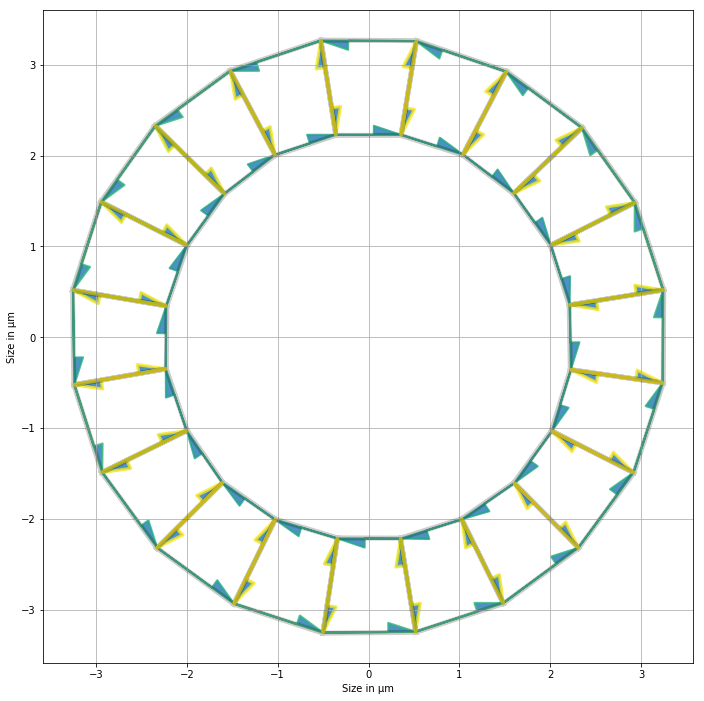

In [14]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas.x[:organo3.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = opt_mat_2_cst_organo.face_df.area + res_2_cst_areas.x[3*organo3.Nf:4*organo3.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo3)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo3, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo3.edge_df.line_tension[:3*organo3.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo3.Nf]))))

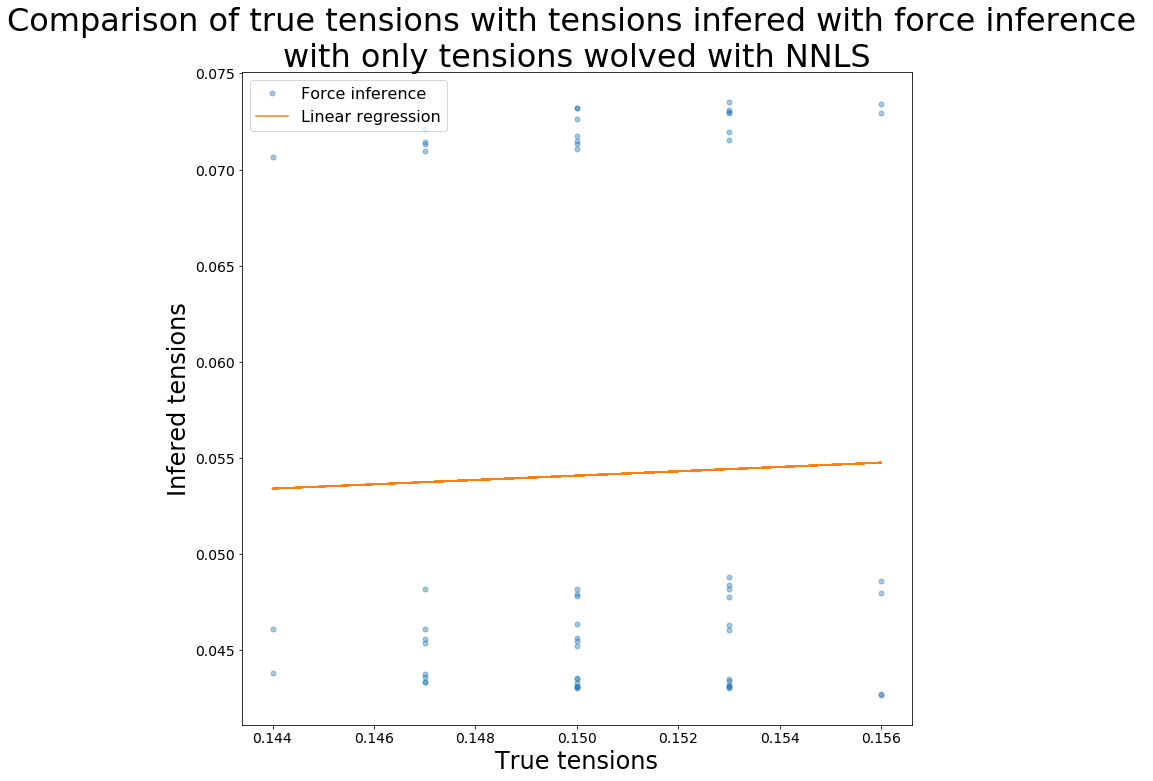

R value : 0.027074833610909822 
Standard error : 0.011143065450190268


In [15]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  res_2_cst_areas.x[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

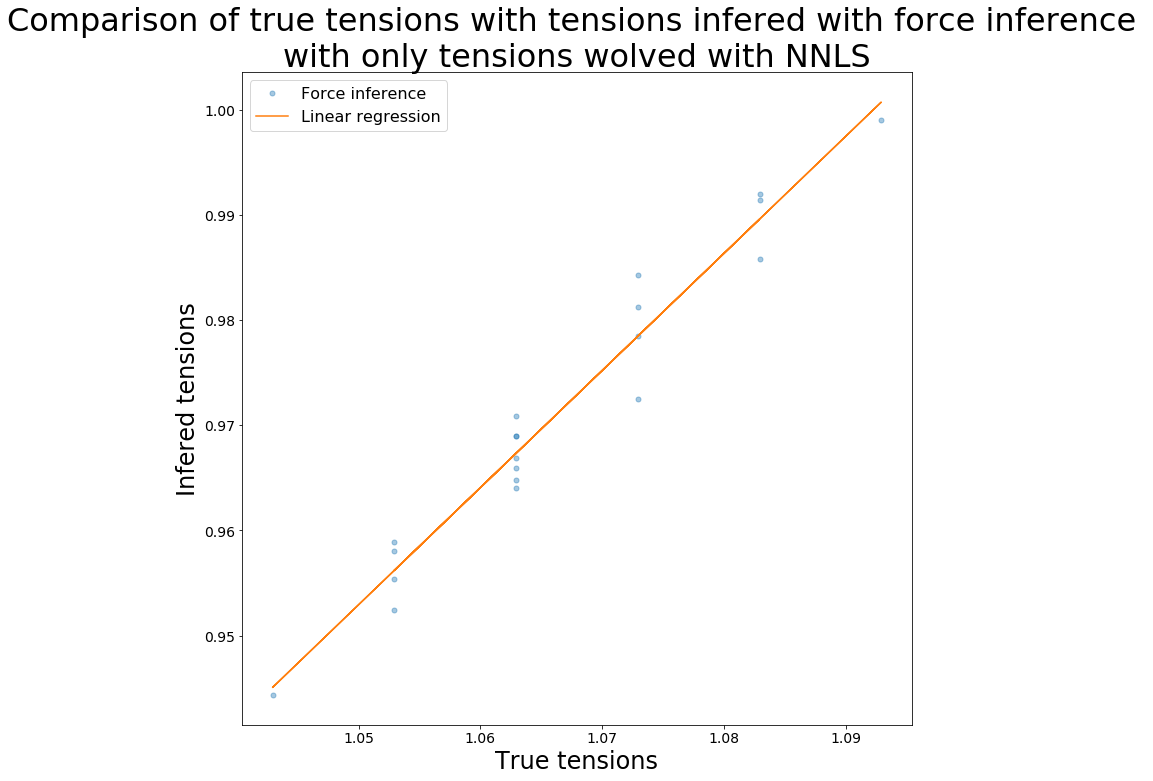

R value : 0.9787851056354064 
Standard error : 0.0014397693383384443


In [16]:
rendering_results(organo3, organo3.face_df.eval('prefered_area'),
                  res_2_cst_areas.x[4*organo3.Nf:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))